# 第6回課題
前処理と特徴量選択により，SVM の最初のスコアよりも1割程度良いテストスコアを出してください．
ちょこっといじった程度では，線形回帰はスコアが変わらなかったので，参考程度に使ってください

### 必須事項
- 前処理：正規化，標準化，外れ値の排除など
- 特徴量選択: 検証は必須．増やす・減らす・変えないの結果は自由
- テストスコアの向上: mse で 0.41 くらいは出ると思います

### 自由事項
- 指標の変更
- パラメータの変更（モデルの変更は想定してません）

### 余談
特徴量選択で正解を用意するのは，やはり難しいなと解答を作る時に感じました．解答の方は最低限の考察と検証をしていますが，4時間かかりました( ;∀;)

## 注意事項
特徴量の分析時に分割したデータを使ってない時点でせこいというか，おかしいです．ここでは無視していますが，本来はできません．

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [122]:
wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
print(wine_quality_df.shape)
wine_quality_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [123]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [124]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## 注意
ここで，test score まで同時に出してしまっているんですが，1つの関数で実行してしまう方が楽だったという理由だけで，これらは分けた方が良いです．
パラメータや特徴量について考えるときには，CV だけで調整すべきです

In [92]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, test=True):
    global X_train, X_test, y_train, y_test, feature_names
    scores = cross_val_score(model, X_train[feature_names], y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    if test:
        model.fit(X_train[feature_names], y_train)
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(mean_squared_error(y_test, pred)))

# モデルによる予測

In [0]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48812538 0.48841541 0.42327305 0.42566563 0.36728215]
Average score: 0.43855232598926497
Test score: 0.40104663051541495


In [9]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48812538 0.48841541 0.42327305 0.42566563 0.36728215]
Average score: 0.43855232598926497
Test score: 0.40104663051541484


In [0]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.70535714 0.82142857 0.67857143 0.71875    0.56950673]
Average score: 0.6987227738629085
Test score: 0.5895833333333333


In [34]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.67857143 0.82142857 0.71428571 0.75446429 0.62780269]
Average score: 0.719310538116592
Test score: 0.68125


In [0]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.53300496 0.55297245 0.47889385 0.55125217 0.42733588]
Average score: 0.5086918627733359
Test score: 0.4598637954554451


In [35]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.5715145  0.68175944 0.57909369 0.61098986 0.50245379]
Average score: 0.5891622546486783
Test score: 0.5085468469038228


# 以降にコードを追加

In [125]:
#標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train.iloc[:,:] = ss.fit_transform(X_train)
X_test.iloc[:,:] = ss.transform(X_test)

In [126]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)
print('------------------------')
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.56696429 0.52678571 0.5        0.52678571 0.4529148 ]
Average score: 0.5146901024983984
Test score: 0.4583333333333333
------------------------
Cross-Validation scores: [0.45148575 0.42211498 0.38000374 0.4269028  0.3493321 ]
Average score: 0.40596787342893403
Test score: 0.3873727306496461


外れ値の確認

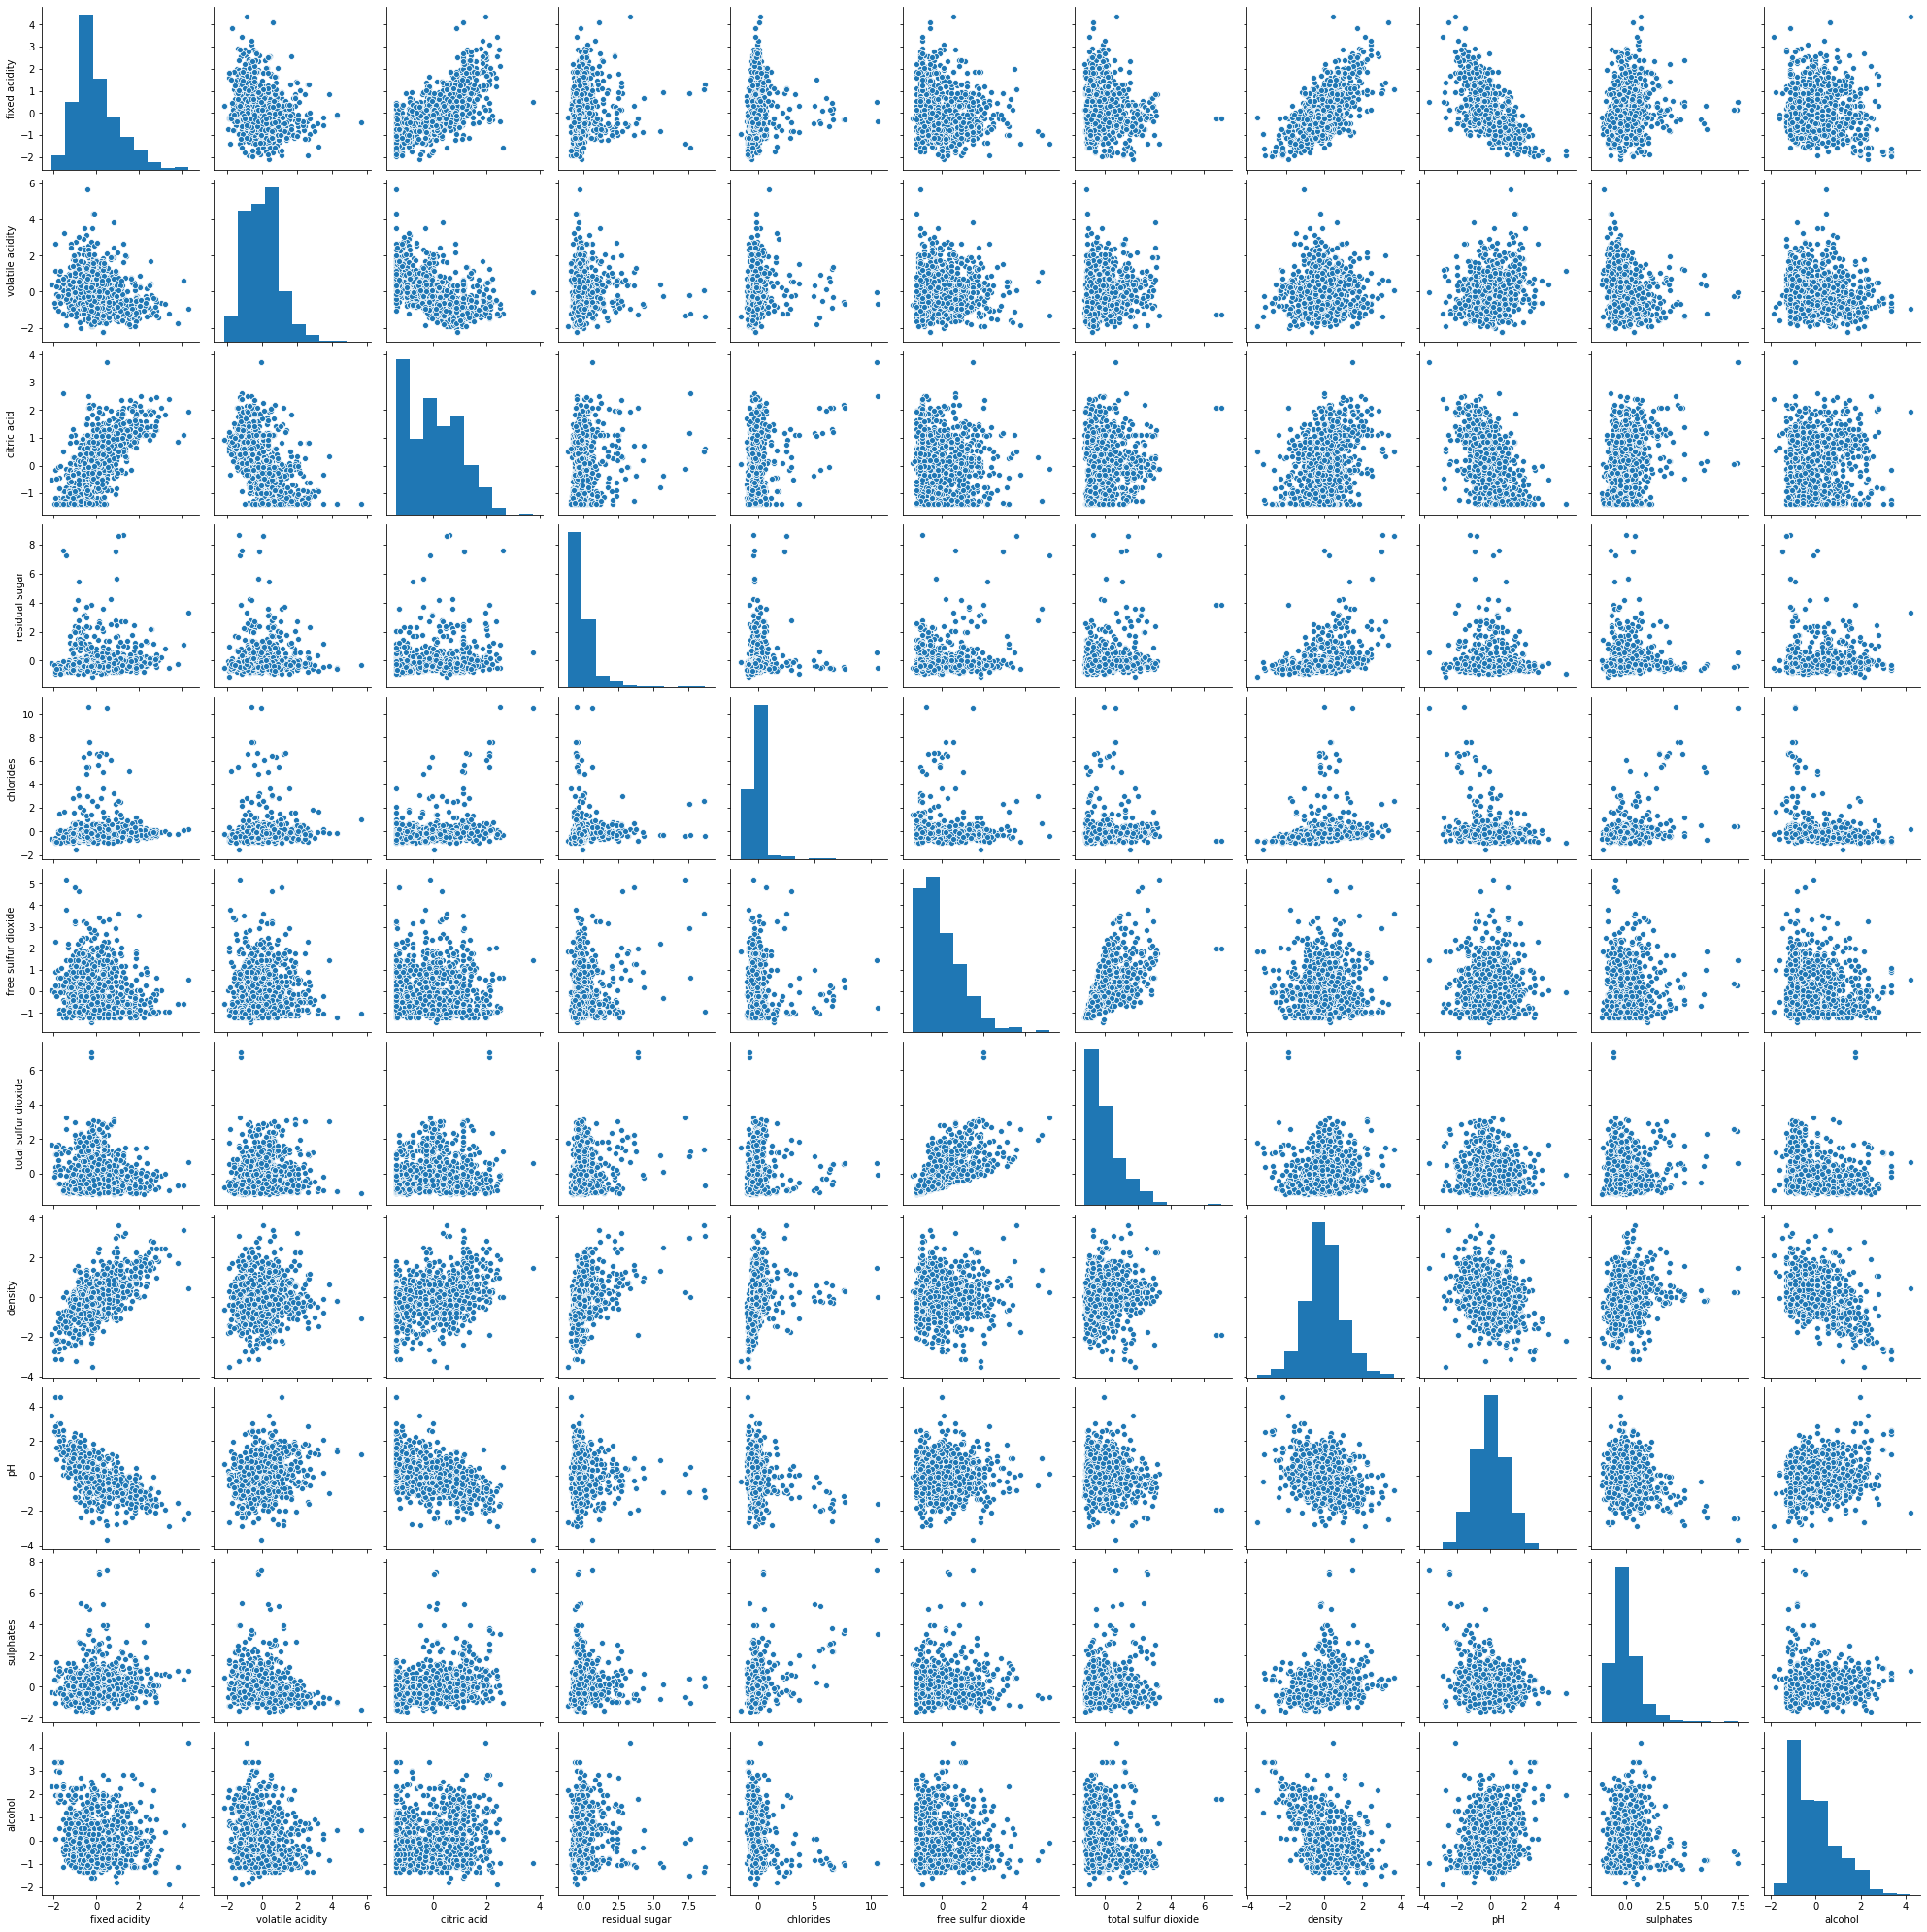

In [62]:
import seaborn as sns
sns.pairplot(X_train)

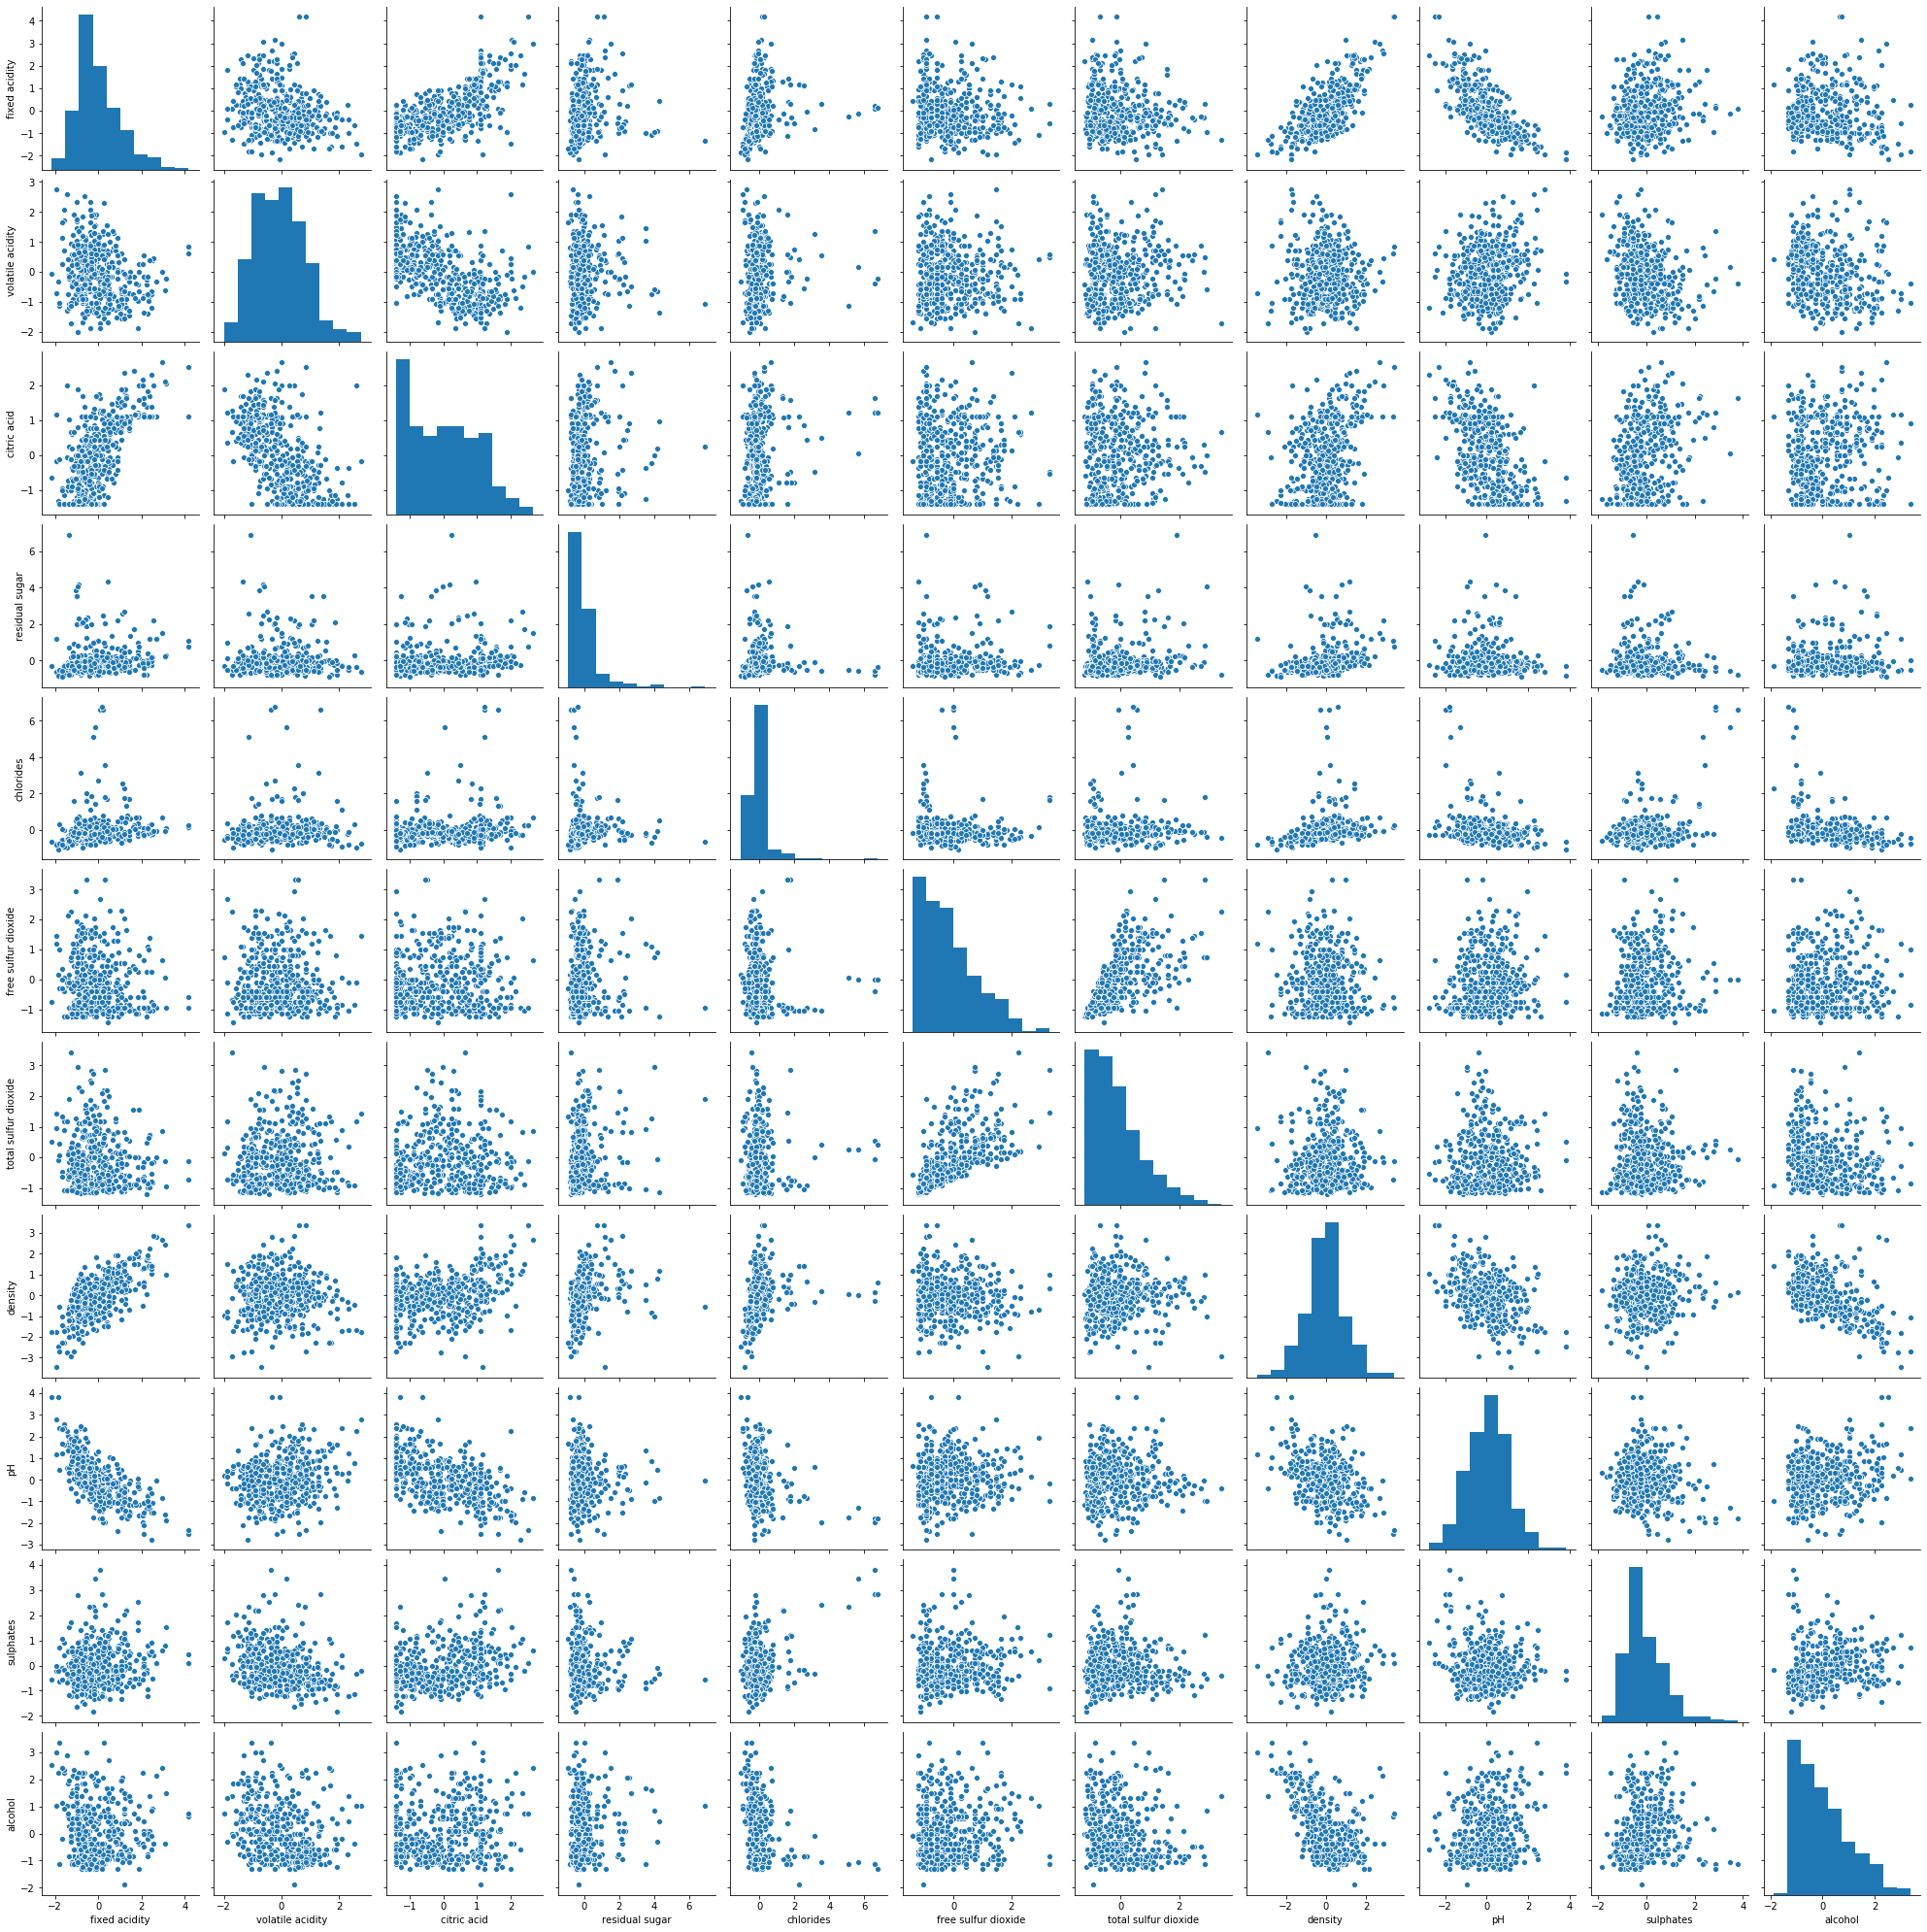

In [63]:
sns.pairplot(X_test)

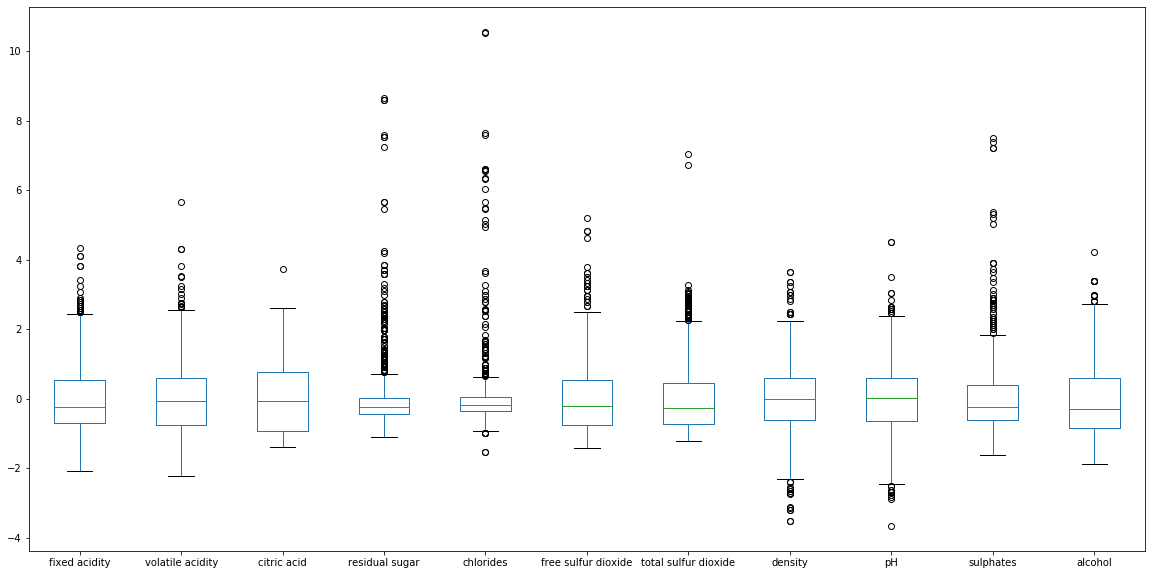

In [64]:
X_train.plot.box(figsize=(20,10))

In [127]:
#散布図を見て外れ値の置換
X_train.loc[X_train[X_train['chlorides']>8].index,'chlorides']=0
X_train.loc[X_train[X_train['total sulfur dioxide']>4].index,'total sulfur dioxide']=0
X_train.loc[X_train[X_train['citric acid']>3].index,'citric acid']=0

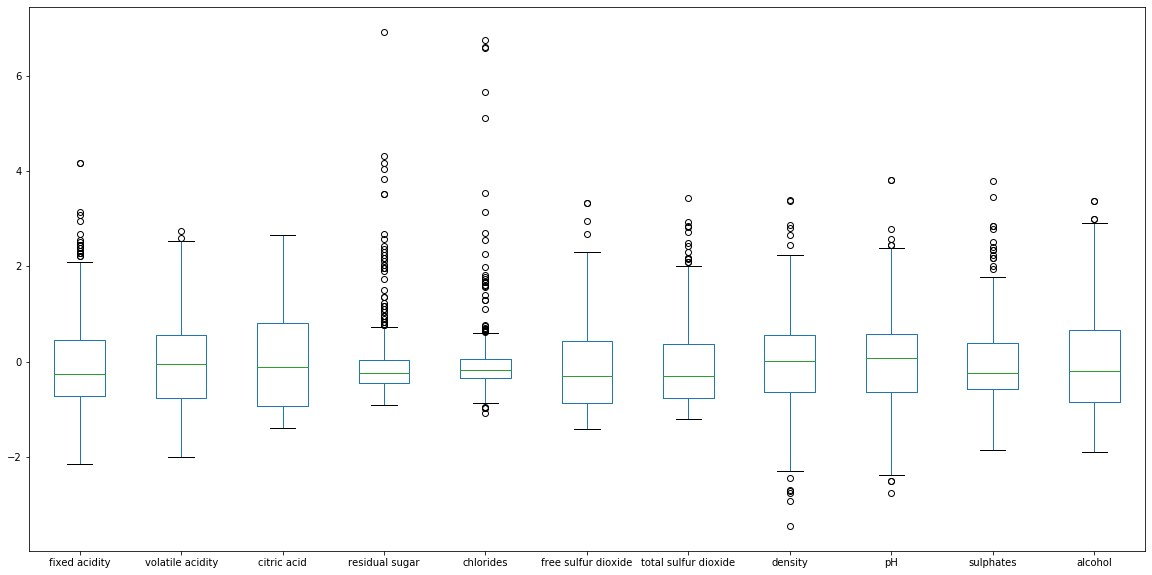

In [65]:
X_test.plot.box(figsize=(20,10))

In [128]:
#散布図を見て外れ値の置換
X_test.loc[X_test[X_test['fixed acidity']>4].index,'fixed acidity']=0
X_test.loc[X_test[X_test['residual sugar']>6].index,'residual sugar']=0
X_test.loc[X_test[X_test['chlorides']>4].index,'chlorides']=0

In [114]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1115, 11), (480, 11), (1115,), (480,))

In [115]:
#外れ値除外後
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)
print('------------------------')
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.56950673 0.52914798 0.49327354 0.52466368 0.43497758]
Average score: 0.5103139013452915
Test score: 0.45625
------------------------
Cross-Validation scores: [0.45420577 0.42322929 0.37975061 0.42849759 0.33923099]
Average score: 0.40498285167923675
Test score: 0.3877211581504535


In [130]:
#標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train.iloc[:,:] = ss.fit_transform(X_train)
X_test.iloc[:,:] = ss.transform(X_test)

In [131]:
#外れ値除外後
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)
print('------------------------')
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.56696429 0.52678571 0.5        0.52232143 0.43497758]
Average score: 0.510209801409353
Test score: 0.4479166666666667
------------------------
Cross-Validation scores: [0.45244336 0.42198439 0.37812149 0.42541199 0.34637916]
Average score: 0.40486807502133804
Test score: 0.382129807017762


特徴量の変更

In [135]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


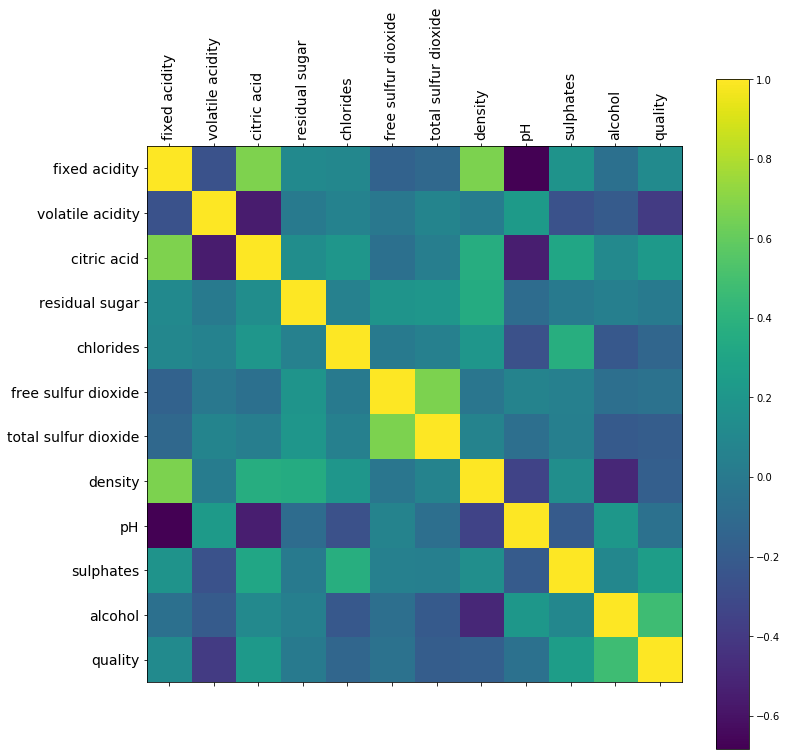

In [136]:
fig = plt.figure(figsize=(12, 12))
plt.matshow(wine_quality_df.corr("pearson"), fignum=fig.number)
plt.xticks(range(wine_quality_df.shape[1]), wine_quality_df.columns, fontsize=14, rotation=90)
plt.yticks(range(wine_quality_df.shape[1]), wine_quality_df.columns, fontsize=14)
plt.colorbar()

In [138]:
# どういう組み合わせで相関が大きいか見ておきましょう（0.4はなんとなくです．根拠はありません）
corr = wine_quality_df.corr().values
[[wine_quality_df.columns[i], wine_quality_df.columns[j], corr[i][j]] for i in range(wine_quality_df.shape[1]-1) for j in range(i,wine_quality_df.shape[1]-1) if abs(corr[i][j]) >= 0.4 and corr[i][j] != 1]

[['fixed acidity', 'citric acid', 0.6717034347641041],
 ['fixed acidity', 'density', 0.6680472921189711],
 ['fixed acidity', 'pH', -0.6829781945685299],
 ['volatile acidity', 'citric acid', -0.5524956845595839],
 ['citric acid', 'pH', -0.5419041447395132],
 ['free sulfur dioxide', 'total sulfur dioxide', 0.6676664504810212],
 ['density', 'alcohol', -0.49617977024170085]]

fixed acidityが3つの特徴量と相関が大きいので削除

In [139]:
feature_names.remove("fixed acidity")

In [140]:
#外れ値除外後
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)
print('------------------------')
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.56696429 0.53571429 0.52232143 0.52678571 0.44394619]
Average score: 0.5191463805253044
Test score: 0.4375
------------------------
Cross-Validation scores: [0.45718033 0.42371767 0.38019791 0.42865694 0.34906874]
Average score: 0.4077643163099868
Test score: 0.38408741219363646


fixed acidityは削除しても変わらない(もう一つ相関が大きい'total sulfur dioxide'を削除したが0.02ほど悪くなった)